## 데이터 읽기

In [1]:
import glob
import os
import re
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

txt_file_path = '/home/aiffel0049/aiffel/Exploration/11.make_sentence/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt파일을 모두 읽음 -> raw_corpus에 담음
for txt_file in txt_list:
    with open(txt_file, 'r') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
print('데이터 크기: ', len(raw_corpus))
print('Examples: \n', raw_corpus[:3])

데이터 크기:  187088
Examples: 
 ["I'll undress you, 'cause you're tired", 'Cover you as you desire', 'When you fall asleep inside my arms']


## 데이터 정제

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  # 소문자 전환, 띄어쓰기 제거
    
    sentence = re.sub(r'([?.!,¿])', r' \1 ', sentence)  # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', ' ', sentence)   # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r'[^a-zA-Z?.!,¿\']+', " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    
    sentence = sentence.strip()
    
    sentence = '<start> ' + sentence + ' <end>'  # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This's @_is ;;;sample        sentence."))

<start> this's is sample sentence . <end>


In [3]:
raw_corpus[:10]

["I'll undress you, 'cause you're tired",
 'Cover you as you desire',
 'When you fall asleep inside my arms',
 'May not have the fancy things',
 "But I'll give you everything",
 "You could ever want, it's in my arms So baby tell me yes",
 'And I will give you everything',
 'So baby tell me yes',
 'And I will be all yours tonight',
 'So baby tell me yes']

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    
    corpus.append(preprocess_sentence(sentence))

corpus[:10]

["<start> i'll undress you , 'cause you're tired <end>",
 '<start> cover you as you desire <end>',
 '<start> when you fall asleep inside my arms <end>',
 '<start> may not have the fancy things <end>',
 "<start> but i'll give you everything <end>",
 "<start> you could ever want , it's in my arms so baby tell me yes <end>",
 '<start> and i will give you everything <end>',
 '<start> so baby tell me yes <end>',
 '<start> and i will be all yours tonight <end>',
 '<start> so baby tell me yes <end>']

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,
        filters=' ',
        oov_token='<unk>'
    )
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   95 3211 ...    0    0    0]
 [   2 1195    7 ...    0    0    0]
 [   2   42    7 ...    0    0    0]
 ...
 [   2   25   71 ...    0    0    0]
 [   2   38   23 ...    0    0    0]
 [   2   25   71 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f275cdd6bd0>


In [6]:
max_len = 15
src_input = tensor[:, :max_len]
tgt_input = tensor[:, 1:max_len+1]

print(src_input.shape)
print(tgt_input.shape)

(175986, 15)
(175986, 15)


## 평가 데이터셋 분리

In [7]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.29,
                                                          random_state=2020)

In [9]:
print('Source Train : ', enc_train.shape)
print('Target Train : ', dec_train.shape)

Source Train :  (124950, 15)
Target Train :  (124950, 15)


In [10]:
dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<BatchDataset shapes: ((256, 15), (256, 15)), types: (tf.int32, tf.int32)>

In [11]:
dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
dataset_val

<BatchDataset shapes: ((256, 15), (256, 15)), types: (tf.int32, tf.int32)>

## 인공지능 모델 만들기

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size * 2, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(VOCAB_SIZE, embedding_size, hidden_size)

In [13]:
model.build((VOCAB_SIZE, embedding_size))
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  25174016  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 58,083,297
Trainable params: 58,083,297
Non-trainable params: 0
_________________________________________________________________


https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
- param 수

        params = dim(W) + dim(V) + dim(U) = 4n(m+n+1)
        n = hidden layer 차원
        m = input layer 차원
        
        embedding
            params : 3072256
            vocab_size : 12001
            embedding_size : 256
        lstm-1
            params : 5246976
            input : m=256 
            hidden : n=1024
            bias : 1
        lstm-2
            params : 8392704
            input : 1024
            hidden : 1024
            bias : 1
        dense
            params : 12301025
            input : 1024
            hidden(output) : 12001
            bias : 1            

In [14]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit
- fit에서 train, val 넣기

In [15]:
#Loss
epochs = 10
lr = 2e-3
decay = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

Epoch 1/10
488/488 [==============================] - 822s 2s/step - loss: 3.4227 - val_loss: 3.0370
Epoch 2/10
488/488 [==============================] - 196s 401ms/step - loss: 2.8697 - val_loss: 2.7887
Epoch 3/10
488/488 [==============================] - 194s 398ms/step - loss: 2.5947 - val_loss: 2.6416
Epoch 4/10
488/488 [==============================] - 195s 400ms/step - loss: 2.3506 - val_loss: 2.5376
Epoch 5/10
488/488 [==============================] - 208s 426ms/step - loss: 2.1237 - val_loss: 2.4608
Epoch 6/10
488/488 [==============================] - 208s 427ms/step - loss: 1.9110 - val_loss: 2.4062
Epoch 7/10
488/488 [==============================] - 194s 398ms/step - loss: 1.7160 - val_loss: 2.3696
Epoch 8/10
488/488 [==============================] - 191s 391ms/step - loss: 1.5410 - val_loss: 2.3518
Epoch 9/10
488/488 [==============================] - 197s 404ms/step - loss: 1.3867 - val_loss: 2.3481
Epoch 10/10
488/488 [==============================] - 204s 417ms/s

In [16]:
history = history.history

In [17]:
model_path = '/home/aiffel0049/aiffel/Exploration/11.make_sentence/models/'
val_loss = history['val_loss'][-1]
model.save_weights(model_path + 'lstm_' + str(val_loss)[:6] + '.h5')

dict_keys(['loss', 'val_loss'])


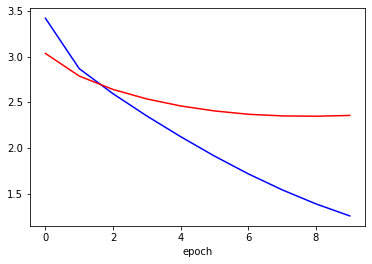

In [18]:
print(history.keys())

# acc = history['acc']
losses = history['loss']
# val_acc = history['val_acc']
val_loss = history['val_loss']

plt.plot(losses, 'b', label='train_loss')
plt.plot(val_loss, 'r', label='val_loss')
plt.xlabel('epoch')

plt.show()

In [19]:
def generate_text(model, tokenizer, init_sentence='<start>', max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    # 텍스트를 실제로 생성할 때, 루프를 돌면서 단어 하나씩 생성해야 함
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]  # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됨
        
        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여줌
        test_tensor = tf.concat([test_tensor, 
                                tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 우리 모델이 <END>를 예측 or max_len에 도달하지 않았다면, while 루프를 돌며 다음 단어 예측해야 함
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break
    
    generated = ''
    # 생성된 tensor안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
    
    return generated  # 이것이 최종적으로 모델이 생성한 자연어 문장

In [20]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much , i love you so much , i love you so much , i '

## 실험내용

1. 기본

        embedding_size = 256
        hidden_size = 1024
        lr=1e-3
        
        loss: 2.2793 - val_loss: 2.5783

        '<start> i love you , i need you <end> '

2. embedding_size = 512
        
        embedding_size = 512
        hidden_size = 1024
        lr=1e-3

        val_loss: 2.5551
        
        <start> i love you , i love you , i love you , i love <end>

3. hidden_size=512
        
        embedding_size = 256
        hidden_size = 512
        lr=1e-3

        loss: 2.6123 - val_loss: 2.7325
        
        "<start> i love you , i don't know what i do <end> "

4. layer node 변경
        
        embedding_size = 256
        hidden_size = 1024, 512 (1, 2 layer)
        lr=1e-3
        
        loss: 2.7151 - val_loss: 2.8008
        
        "<start> i love you , i don't know , i don't know , i know "

5. decay = 5e-4

        embedding_size = 256
        hidden_size = 1024, 512 (1, 2 layer)
        lr=1e-3, decay=5e-4

        loss: 2.6293 - val_loss: 2.7735
        
        "<start> i love you , i don't know what i want <end> "

6. decay = 5e-5
        
        embedding_size = 256
        hidden_size = 1024
        lr=1e-3, decay=5e-5

        loss: 2.3956 - val_loss: 2.6381
        
        '<start> i love you , i love you <end> '

7. lr=3e-3

        embedding_size = 256
        hidden_size = 1024
        lr=3e-3

        loss: 1.8772 - val_loss: 2.4724
        
        '<start> i love ma little nasty girl <end> '

8. lr=3e-3, decay=5e-5

        embedding_size = 256
        hidden_size = 1024
        lr=3e-3, decay=5e-5

        loss: 1.2963 - val_loss: 2.3904
        
        '<start> i love you , i love you <end> '

9. layer 3개, lr=3e-3, decay=5e-5

        embedding_size = 256
        hidden_size = 1024 (3 layer)
        lr=3e-3, decay=5e-5
        
        loss: 2.5328 - val_loss: 2.7627
        
        "<start> i love you , i don't wanna , i don't wanna , i don't "
        
10. layer 4개, hidden_size=512, lr=3e-3, decay=5e-5

        embedding_size = 256
        hidden_size = 512 (4 layer)
        lr=3e-3, decay=5e-5
        
        loss: 2.6150 - val_loss: 2.8053
        
        "<start> i love you , i don't know what i want <end> "
        
11. hidden_size=1024, 2048, lr=3e-3, decay=5e-5

        embedding_size = 256
        hidden_size = 1024, 2048
        lr=3e-3, decay=5e-5
        
        loss: 1.0288 - val_loss: 2.4507
        
        '<start> i love you mom , you always be my favorite girl . <end> '
        
        epoch 6부터 fit

12. hidden_size=1024, 2048, lr=2e-3, decay=5e-5

        embedding_size = 256
        hidden_size = 1024, 2048
        lr=3e-3, decay=5e-5
        
        loss: 1.2548 - val_loss: 2.3568
        
        '<start> i love you so much , i love you so much , i love you so much , i '